In [1]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

project_root = Path.cwd().resolve().parent  # parent of notebooks/
sys.path.append(str(project_root))

from src.event_impact_modeling import EventImpactModeler

In [10]:
model = EventImpactModeler(
    data_path="../data/processed/ethiopia_fi_enriched_data.csv",
    impact_links_path="../data/processed/ethiopia_fi_impact_links.csv",
    ramp_months=6
)


2026-02-02 11:23:06,240 | INFO | Loaded 14 events, 32 observations, 5 impact links


In [11]:
summary = model.event_indicator_summary()
summary


,parent_id,indicator,category,event_date,pillar,related_indicator,impact_direction,impact_magnitude,lag_months,confidence
0,EVT_AGENT_REG,NaN,NaN,NaT,ACCESS,ACC_ACCOUNT_OWNERSHIP,increase,medium,12.0,medium
1,EVT_TELEBIRR,NaN,NaN,NaT,USAGE,ACC_MM_ACCOUNT,increase,high,6.0,high
2,EVT_TELEBIRR,NaN,NaN,NaT,USAGE,USG_DIGITAL_PAYMENT,increase,high,6.0,high
3,EVT_4G_EXPANSION,NaN,NaN,NaT,ACCESS,ACC_MOBILE_PEN,increase,medium,18.0,medium
4,EVT_FAYDA,NaN,NaN,NaT,ACCESS,ACC_ACCOUNT_OWNERSHIP,increase,medium,12.0,medium


In [12]:
assoc = model.build_association_matrix()
assoc


indicator,ACC_ACCOUNT_OWNERSHIP,ACC_MM_ACCOUNT,ACC_MOBILE_PEN,USG_DIGITAL_PAYMENT
event_id,,,,
EVT_4G_EXPANSION,0.0,0.0,1.5,0.0
EVT_AGENT_REG,1.5,0.0,0.0,0.0
EVT_FAYDA,1.5,0.0,0.0,0.0
EVT_TELEBIRR,0.0,3.0,0.0,3.0


Text(0.5, 1.0, 'Event–Indicator Association Matrix')

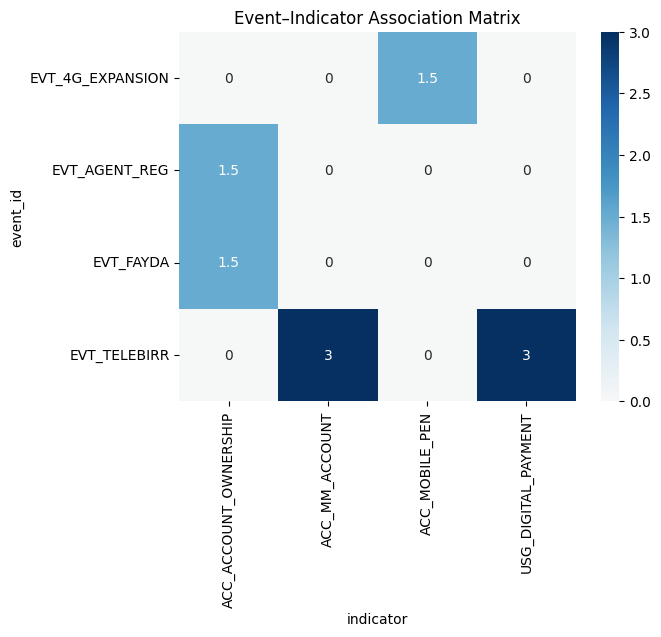

In [13]:
sns.heatmap(assoc, annot=True, cmap="RdBu", center=0)
plt.title("Event–Indicator Association Matrix")


In [14]:
telebirr_test = model.validate_against_actual("ACC_MM_ACCOUNT")
telebirr_test


,value_numeric,simulated,error_pp
observation_date,,,
2021-12-31,4.70,4.7,0.00
2024-11-29,9.45,4.7,-4.75


Text(0, 0.5, 'Percentage')

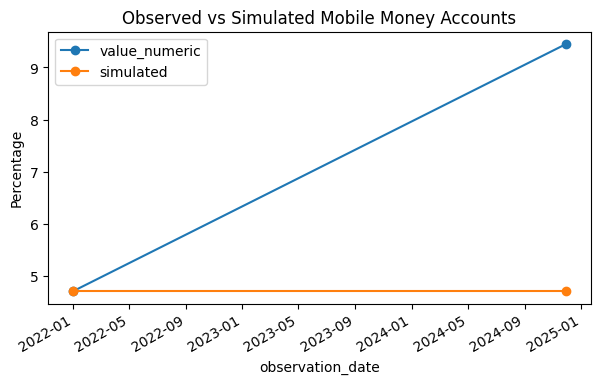

In [15]:
telebirr_test[["value_numeric", "simulated"]].plot(
    marker="o", figsize=(7,4)
)
plt.title("Observed vs Simulated Mobile Money Accounts")
plt.ylabel("Percentage")
